In [71]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [72]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / 'data' / 'Titanic-Dataset.csv'

In [73]:
df = pd.read_csv(data_path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [74]:
df.shape

(891, 12)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* Lets impute missing values for Embarked since it seems like it may contribute to predicting Pclass and hence survival

In [76]:
df['Embarked'] = df.groupby('Pclass')['Embarked'].transform(lambda x: x.fillna(x.mode()[0]))

* From above information we see that a number of rows are missing.
* its important to identify columns that are crucial for our prediction and know how to deal with them
* Age seems like a good predictor which needs to be dealt with regarding its null values

In [77]:
df[df.Age.isnull()]['Survived'].value_counts()

Survived
0    125
1     52
Name: count, dtype: int64

In [78]:
#find number of passengers who survived
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

* The total number of passengers who survived is 342
* 52 of them have unknown age, while 125 of them our of the 549 who died have unknown age
* it would not be appropriate for us to discard the null age values



### Lets try to find a way to impute the Age
* we could try by first seeing the relationship various features such as Pclass, Sex have with Age and Survived

In [79]:
cols_to_encod = df.drop(columns=['PassengerId','Name','Ticket','Cabin','Embarked'])

In [80]:
cols_to_encod.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [81]:
df_encoded = pd.get_dummies(cols_to_encod,drop_first=True)

In [82]:
df_encoded.corr(method='spearman')['Age']

Survived   -0.052565
Pclass     -0.361666
Age         1.000000
SibSp      -0.182061
Parch      -0.254212
Fare        0.135051
Sex_male    0.083330
Name: Age, dtype: float64

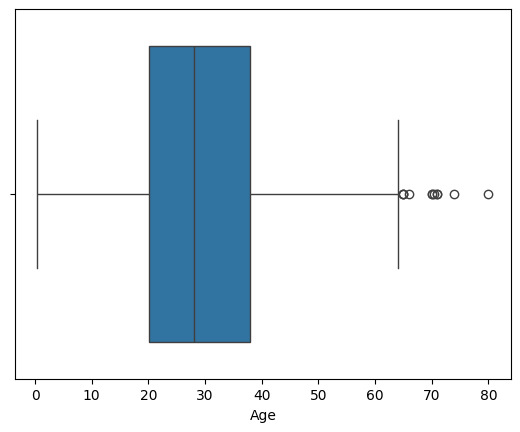

In [83]:
sns.boxplot(df,x='Age')
plt.show()

* Above boxplot shows there are some outliers which means we may not use mean as an imputer


In [84]:
df.groupby(['Sex','Pclass'])['Age'].mean()

Sex     Pclass
female  1         34.611765
        2         28.722973
        3         21.750000
male    1         41.281386
        2         30.740707
        3         26.507589
Name: Age, dtype: float64

* Above groupby() shows that age tended to change based on class, i.e. the 1st class tends to have older populations in both sexes

In [85]:
df['Age'] = df.groupby(['Sex','Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

* After imputing missing age
* Lets check for outliers in Fare, Sibsp, Parch columns

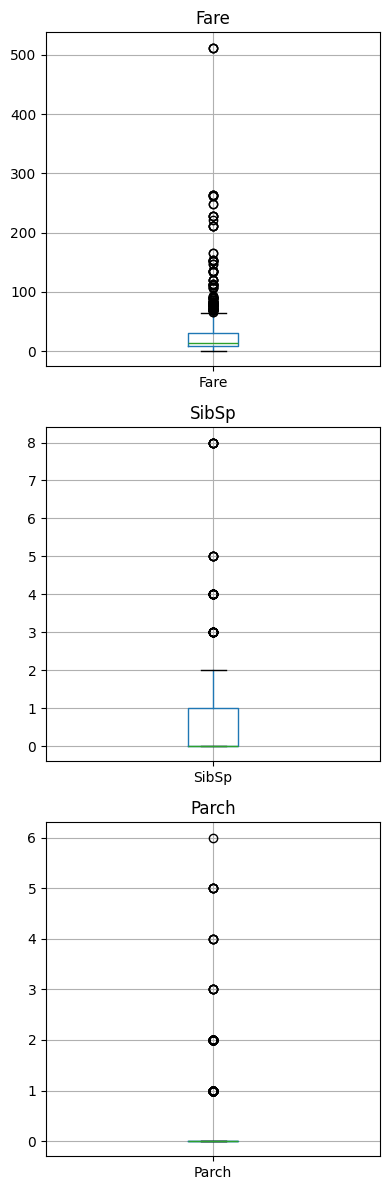

In [86]:
col = ['Fare','SibSp','Parch']

fig,axes = plt.subplots(3,1,figsize=(4,12))

for i,c in enumerate(col):
    df.boxplot(column=c,ax=axes[i])
    axes[i].set_title(c)

plt.tight_layout()
plt.show()

In [87]:
import numpy as np

* All our select columns have outliers which must be factored in analysis/modeling

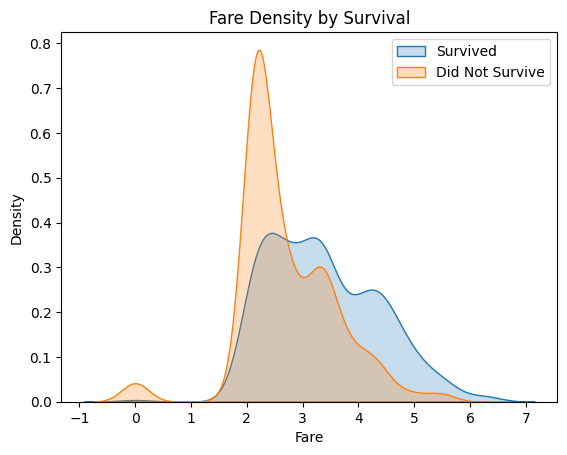

In [88]:
sns.kdeplot(df.loc[df['Survived'] == 1, 'Fare'].apply(lambda x: np.log1p(x)), label='Survived', fill=True)
sns.kdeplot(df.loc[df['Survived'] == 0, 'Fare'].apply(lambda x: np.log1p(x)), label='Did Not Survive', fill=True)
plt.title("Fare Density by Survival")
plt.legend()
plt.show()


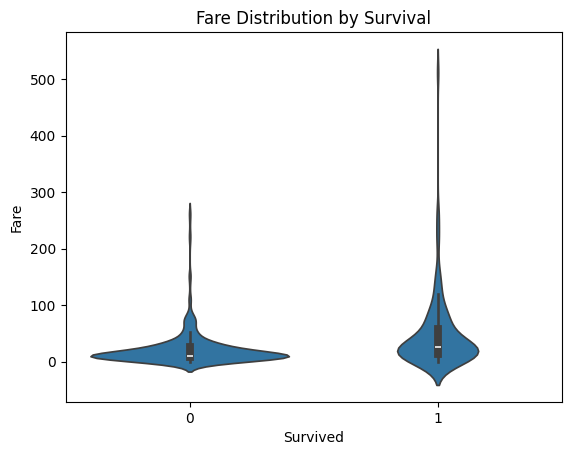

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x='Survived', y='Fare', data=df)
plt.title("Fare Distribution by Survival")
plt.show()


In [90]:
df.Fare.mean()

np.float64(32.204207968574636)

In [91]:
df.groupby('Survived')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


In [92]:
fare_surv = df[df.Survived == 1][['Fare','Survived']]
above_mean_count = (fare_surv > 0.0) & (fare_surv <= 100.0)
above_mean_count.value_counts()


Fare   Survived
True   True        302
False  True         40
Name: count, dtype: int64

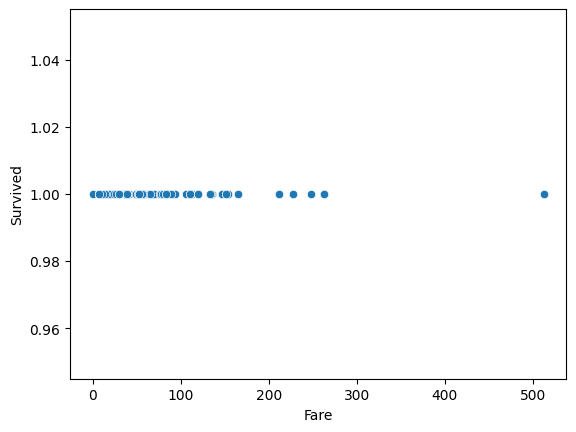

In [93]:
sns.scatterplot(data=fare_surv,x='Fare',y='Survived')
plt.show()

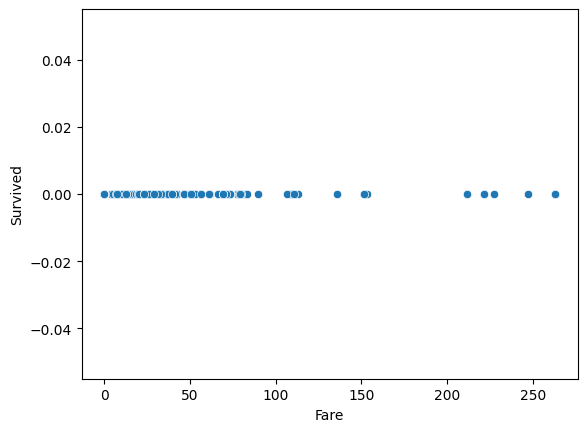

In [94]:
fare_surv_die = df[df.Survived == 0][['Fare','Survived']]
sns.scatterplot(data=fare_surv_die,x='Fare',y='Survived')
plt.show()

* The above plots and statistics prove that majorly the one's who paid higher fares had a higher chance of survival compared to those who paid below the mean fare which is (32)
* Those who survived paid significantly higher than the mean for fare

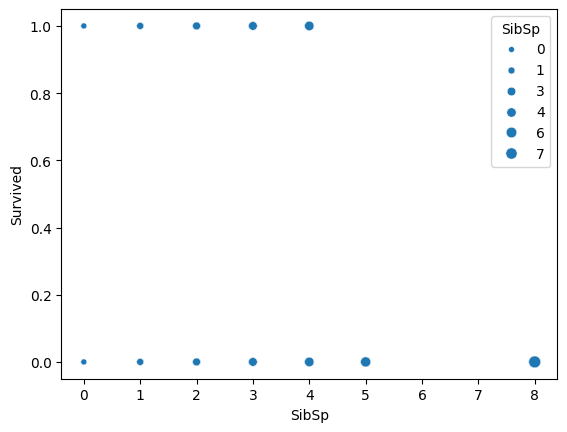

In [95]:
sns.scatterplot(data=df,x='SibSp',y='Survived',size='SibSp')
plt.show()

In [96]:
sibs = df[df.SibSp >= 1][['SibSp','Survived','Parch']]
sibs.groupby('Survived').describe()

SibSp                                               Parch            \
          count      mean       std  min  25%  50%  75%  max  count      mean   
Survived                                                                        
0         151.0  2.013245  1.762524  1.0  1.0  1.0  3.0  8.0  151.0  0.913907   
1         132.0  1.227273  0.612726  1.0  1.0  1.0  1.0  4.0  132.0  0.674242   

                                             
               std  min  25%  50%  75%  max  
Survived                                     
0         1.136899  0.0  0.0  1.0  2.0  6.0  
1         0.869291  0.0  0.0  0.0  1.0  5.0

* Above statistics show that having a sibling did not determine whether one survived, as one would think a sibling would save you

In [97]:
pars = df[df['Parch'] >= 1][['Survived','Parch','SibSp']]
pars.groupby('Survived').describe()

Parch                                               SibSp            \
          count      mean       std  min  25%  50%  75%  max  count      mean   
Survived                                                                        
0         104.0  1.740385  1.061188  1.0  1.0  1.0  2.0  6.0  104.0  2.125000   
1         109.0  1.458716  0.645958  1.0  1.0  1.0  2.0  5.0  109.0  0.770642   

                                             
               std  min  25%  50%  75%  max  
Survived                                     
0         2.206291  0.0  1.0  1.0  4.0  8.0  
1         0.888538  0.0  0.0  1.0  1.0  4.0

* Also having a parent or sibling did not determine whether one survived or not

## Now lets check survival by sex

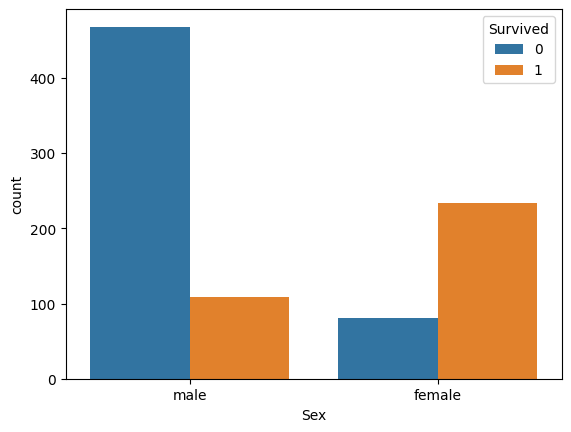

In [98]:
sns.countplot(data=df,x='Sex',hue='Survived')
plt.show()

In [99]:
df.groupby(['Survived','Sex'])['Sex'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

* Females survived more
* Lets see survival by age and sex impact

In [100]:
df['Age_group'] = pd.cut(x=df.Age,bins=[0,12,18,35,50,80],labels=['Child','Teen','Youth','Adult','Senior'])
df['Age_group'].value_counts()

Age_group
Youth     514
Adult     174
Teen       70
Child      69
Senior     64
Name: count, dtype: int64

In [101]:
df.groupby(['Survived','Age_group'])['Age_group'].count()

/var/folders/n6/qbm6l1m51lq2lhh9c88h6ftr0000gq/T/ipykernel_26272/2169336066.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Survived','Age_group'])['Age_group'].count()


Survived  Age_group
0         Child         29
          Teen          40
          Youth        330
          Adult        108
          Senior        42
1         Child         40
          Teen          30
          Youth        184
          Adult         66
          Senior        22
Name: Age_group, dtype: int64

In [102]:
df.groupby(['Survived','Age_group','Sex'])[['Age_group','Sex']].count()

/var/folders/n6/qbm6l1m51lq2lhh9c88h6ftr0000gq/T/ipykernel_26272/2805662451.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Survived','Age_group','Sex'])[['Age_group','Sex']].count()


Age_group  Sex
Survived Age_group Sex                   
0        Child     female         13   13
                   male           16   16
         Teen      female          9    9
                   male           31   31
         Youth     female         43   43
                   male          287  287
         Adult     female         15   15
                   male           93   93
         Senior    female          1    1
                   male           41   41
1        Child     female         19   19
                   male           21   21
         Teen      female         27   27
                   male            3    3
         Youth     female        130  130
                   male           54   54
         Adult     female         41   41
                   male           25   25
         Senior    female         16   16
                   male            6    6

* It seems like the females were the majority in all categories that survived.
* Also it seems children were priorized in being saved and helped to survive

## Let's Predict whether a Passenger Survived or not
* We use classification method to get binary values 0/1 

In [103]:
# Lets find out if the data is imbalanced 
# imbalanced data is one with a ration where minority class < 30%

df.Survived.value_counts(normalize=True)*100

# since the minority is 38% then our dataset is balanced

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

* There are columns we will drop, for not being useful in modeling eg. Name, PassengerID,Ticket,Cabin

In [104]:
new_df = df.drop(columns=['PassengerId','Name','Ticket','Cabin'])

* We will then encode categorical features using one-hot; columns > Sex, Embarked, Age_group

In [105]:
new_df_encode = pd.get_dummies(new_df,drop_first=True,dtype=int)
new_df_encode

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Age_group_Teen,Age_group_Youth,Age_group_Adult,Age_group_Senior
0,0,3,22.0,1,0,7.2500,1,0,1,0,1,0,0
1,1,1,38.0,1,0,71.2833,0,0,0,0,0,1,0
2,1,3,26.0,0,0,7.9250,0,0,1,0,1,0,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,1,0,0
4,0,3,35.0,0,0,8.0500,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1,0,1,0,1,0,0
887,1,1,19.0,0,0,30.0000,0,0,1,0,1,0,0
888,0,3,21.5,1,2,23.4500,0,0,1,0,1,0,0
889,1,1,26.0,0,0,30.0000,1,0,0,0,1,0,0


In [106]:
new_df_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Age               891 non-null    float64
 3   SibSp             891 non-null    int64  
 4   Parch             891 non-null    int64  
 5   Fare              891 non-null    float64
 6   Sex_male          891 non-null    int64  
 7   Embarked_Q        891 non-null    int64  
 8   Embarked_S        891 non-null    int64  
 9   Age_group_Teen    891 non-null    int64  
 10  Age_group_Youth   891 non-null    int64  
 11  Age_group_Adult   891 non-null    int64  
 12  Age_group_Senior  891 non-null    int64  
dtypes: float64(2), int64(11)
memory usage: 90.6 KB


* We will then scale the columns Age, SibSp, Parch and fare using RobustScaler due to its ability in handling outliers

In [107]:
from sklearn.preprocessing import RobustScaler

In [108]:
new_df_col_scale = new_df_encode[['Age','SibSp','Parch','Fare']]
new_df_col_scale

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500
...,...,...,...,...
886,27.0,0,0,13.0000
887,19.0,0,0,30.0000
888,21.5,1,2,23.4500
889,26.0,0,0,30.0000


In [109]:
scaler = RobustScaler()
df_scaled = scaler.fit_transform(new_df_col_scale)

In [110]:
scaled_df = pd.DataFrame(df_scaled,columns=new_df_col_scale.columns)
scaled_df

,Age,SibSp,Parch,Fare
0,-0.275862,1.0,0.0,-0.312011
1,0.827586,1.0,0.0,2.461242
2,0.000000,0.0,0.0,-0.282777
3,0.620690,1.0,0.0,1.673732
4,0.620690,0.0,0.0,-0.277363
...,...,...,...,...
886,0.068966,0.0,0.0,-0.062981
887,-0.482759,0.0,0.0,0.673281
888,-0.310345,1.0,2.0,0.389604
889,0.000000,0.0,0.0,0.673281


In [111]:
new_df_encode.drop(columns=new_df_col_scale.columns,inplace=True)
new_df_encode

,Survived,Pclass,Sex_male,Embarked_Q,Embarked_S,Age_group_Teen,Age_group_Youth,Age_group_Adult,Age_group_Senior
0,0,3,1,0,1,0,1,0,0
1,1,1,0,0,0,0,0,1,0
2,1,3,0,0,1,0,1,0,0
3,1,1,0,0,1,0,1,0,0
4,0,3,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,1,0,1,0,0
887,1,1,0,0,1,0,1,0,0
888,0,3,0,0,1,0,1,0,0
889,1,1,1,0,0,0,1,0,0


In [112]:
concated_encode_scaled = pd.concat([new_df_encode,scaled_df],axis=1)
concated_encode_scaled

,Survived,Pclass,Sex_male,Embarked_Q,Embarked_S,Age_group_Teen,Age_group_Youth,Age_group_Adult,Age_group_Senior,Age,SibSp,Parch,Fare
0,0,3,1,0,1,0,1,0,0,-0.275862,1.0,0.0,-0.312011
1,1,1,0,0,0,0,0,1,0,0.827586,1.0,0.0,2.461242
2,1,3,0,0,1,0,1,0,0,0.000000,0.0,0.0,-0.282777
3,1,1,0,0,1,0,1,0,0,0.620690,1.0,0.0,1.673732
4,0,3,1,0,1,0,1,0,0,0.620690,0.0,0.0,-0.277363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,1,0,1,0,0,0.068966,0.0,0.0,-0.062981
887,1,1,0,0,1,0,1,0,0,-0.482759,0.0,0.0,0.673281
888,0,3,0,0,1,0,1,0,0,-0.310345,1.0,2.0,0.389604
889,1,1,1,0,0,0,1,0,0,0.000000,0.0,0.0,0.673281


In [113]:
X = concated_encode_scaled.drop(columns='Survived')
y = concated_encode_scaled['Survived']

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X,y,test_size=0.15, random_state=42, stratify=y)


In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42, stratify=y_trainval)

* Lets calculate a baseline accuracy 

In [118]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create the baseline model
dummy = DummyClassifier(strategy='most_frequent')

# Fit on training data
dummy.fit(X_train, y_train)

# Predict
y_pred = dummy.predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_pred)


0.6194029850746269

* 62% is the accuracy, a good model should perform better than this for its adoption

* Now lets import the models we will use

In [119]:
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {'Logistic Regression': LogisticRegression(max_iter=2000),
          #'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest Classifier': RandomForestClassifier(),
          'GB Classifier': GradientBoostingClassifier(),
          'KNN': KNeighborsClassifier()
          }

In [120]:
from sklearn.metrics import f1_score

In [121]:
results = []

for key,model in models.items():
    model.fit(X_train,y_train)
    
    y_val_predict = model.predict(X_val)
    
    accuracy = accuracy_score(y_val,y_val_predict)
    f1_check = f1_score(y_val,y_val_predict)
    
    results.append([key, accuracy, f1_check])
    
    
acc_df = pd.DataFrame(results, columns=['Model','Accuracy','F1'])
print(acc_df)

                      Model  Accuracy        F1
0       Logistic Regression  0.813433  0.774775
1             Decision Tree  0.783582  0.733945
2  Random Forest Classifier  0.835821  0.803571
3             GB Classifier  0.858209  0.811881
4                       KNN  0.820896  0.773585


* Let's fine tune our best three performing models using GridSearch

In [122]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',            # optimize for F1 score
    cv=5,                    # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF parameters:", grid_rf.best_params_)
print("Best RF F1 score:", grid_rf.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


Python(34131) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34132) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34133) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34134) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34145) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34146) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34148) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best RF F1 score: 0.7596967293488484


In [123]:
#from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)

grid_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

print("Best GB parameters:", grid_gb.best_params_)
print("Best GB F1 score:", grid_gb.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best GB parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best GB F1 score: 0.7711007130124777


In [124]:
#from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr = LogisticRegression(max_iter=3000, random_state=42)

grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print("Best LR parameters:", grid_lr.best_params_)
print("Best LR F1 score:", grid_lr.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Docume

Best LR parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best LR F1 score: 0.7410862803370121


/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/suleimanmungai/Documents/DS_Practice/ds_projects/titanic_survival/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [125]:
gb_model = grid_gb.best_estimator_
gb_model.fit(pd.concat([X_train,X_val]),pd.concat([y_train,y_val]))

y_test_gb_predict = gb_model.predict(X_test)
print("Test Accuracy gb:", accuracy_score(y_test, y_test_gb_predict))
print("Test F1 gb:", f1_score(y_test, y_test_gb_predict))

Test Accuracy gb: 0.7910447761194029
Test F1 gb: 0.7142857142857143


In [126]:
lr_model = grid_lr.best_estimator_
lr_model.fit(pd.concat([X_train, X_val]),pd.concat([y_train, y_val]))

y_test_lr_predict = lr_model.predict(X_test)
print("Test Accuracy lr:", accuracy_score(y_test, y_test_lr_predict))
print("Test F1 lr:", f1_score(y_test, y_test_lr_predict))


Test Accuracy lr: 0.8059701492537313
Test F1 lr: 0.7346938775510204


In [127]:
best_model = grid_rf.best_estimator_  

best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_test_pred = best_model.predict(X_test)
print("Test Accuracy rf:", accuracy_score(y_test, y_test_pred))
print("Test F1 rf:", f1_score(y_test, y_test_pred))


Test Accuracy rf: 0.7761194029850746
Test F1 rf: 0.6808510638297872


* Apparently, logistic regression performs better 
* A little research shows the reasons are that: 
    * Tree-based models tend to overfit on small datasets
    * LR generalizes well on small datasets

In [128]:
#Lets check importance of features

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": lr_model.coef_[0],
    "importance": np.abs(lr_model.coef_[0])
}).sort_values("importance", ascending=False)

coef_df


,feature,coefficient,importance
1,Sex_male,-2.820596,2.820596
7,Age_group_Senior,-2.815416,2.815416
6,Age_group_Adult,-2.314941,2.314941
4,Age_group_Teen,-2.043472,2.043472
5,Age_group_Youth,-1.808034,1.808034
0,Pclass,-1.176086,1.176086
9,SibSp,-0.445402,0.445402
3,Embarked_S,-0.443304,0.443304
2,Embarked_Q,0.165702,0.165702
10,Parch,-0.151830,0.151830


In [59]:
print(X_train.columns)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Age_group_Teen', 'Age_group_Youth', 'Age_group_Adult',
       'Age_group_Senior', 'Age', 'SibSp', 'Parch', 'Fare'],
      dtype='object')
